In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
from scipy.stats import norm, skew
from scipy import stats
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
%matplotlib inline

In [2]:
fold_name = os.path.join(os.path.abspath('./'), 'Data/')

In [3]:
os.listdir(fold_name)

['application_test.csv',
 'application_train.csv',
 'baseline_lgb.csv',
 'baseline_lgb_domain_features.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'control.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'log_reg_baseline.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'random_forest_baseline.csv',
 'random_forest_baseline_domain.csv',
 'random_forest_baseline_engineered.csv',
 'sample_submission.csv',
 'submission_final.csv',
 'test_bureau_corrs_removed.csv',
 'test_bureau_raw.csv',
 'test_one.csv',
 'test_previous_raw.csv',
 'train_bureau_corrs_removed.csv',
 'train_bureau_raw.csv',
 'train_previous_raw.csv']

In [4]:
filename = os.path.join(fold_name, 'bureau.csv')
bureau = pd.read_csv(filename)

In [5]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [6]:
bureau.columns.values

array(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY'], dtype=object)

In [7]:
filename = os.path.join(fold_name, 'application_train.csv')
app_train = pd.read_csv(filename)

In [8]:
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns={'SK_ID_BUREAU':'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


### 根据用户id统计原先借贷次数，将借贷次数作为新的特征添加到训练集中，验证新特征是否有用。

In [13]:
app_train = app_train.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
app_train['previous_loan_counts'] = app_train.previous_loan_counts.fillna(0)

In [10]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


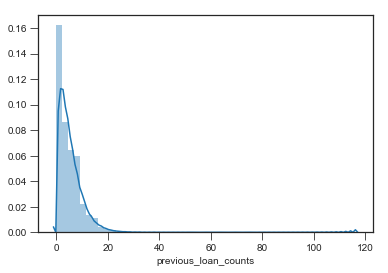

In [11]:
sns.distplot(app_train['previous_loan_counts'])

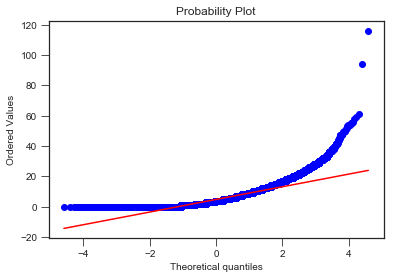

In [12]:
fig = plt.figure()
res = stats.probplot(app_train['previous_loan_counts'], plot=plt)

#### KDE（核密度估计）曲线
核密度估计图显示单个变量的分布（将其视为平滑的直方图）。 要根据分类变量的值来查看不同的分布，我们可以根据类别对分布进行不同的着色。 例如，我们可以通过TARGET = 1还是0来显示previous_loan_count的核密度估计值。由此产生的KDE将显示变量分布与未偿还贷款的人之间的任何显着差异（TARGET == 1 ）和做过的人（TARGET == 0）。 这可以作为变量是否与机器学习模型“相关”的指标。

In [13]:
def kde_target(var_name, df):
    corr = df['TARGET'].corr(df[var_name])
    
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title(f'{var_name} Distribution')
    plt.legend()
    
    print(f'The correlation between {var_name} and the TARGET is {corr:.4f}')
    print(f'Median value for loan that was not repaid = {avg_not_repaid:.4f}')
    print(f'Median value for loan that was repaid =     {avg_repaid:.4f}')    

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


C:\Users\L\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\L\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


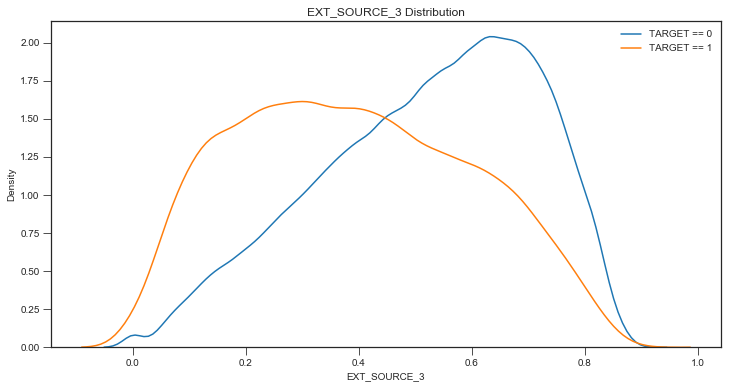

In [14]:
kde_target('EXT_SOURCE_3', app_train)

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


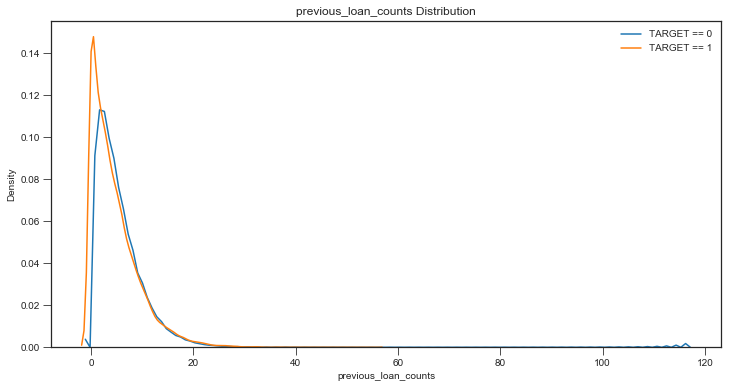

In [15]:
kde_target('previous_loan_counts', app_train)

#### 以上的相关性太弱，而且分布几乎无差别，不太能判定该特征是否有用

### 聚合数字列
将bureau中的数字列特征，以count、mean、max、min、sum等来进行统计

In [16]:
bureau_agg = bureau.drop(columns=['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

In [17]:
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                 ...    DAYS_CREDIT_UPDATE                               \
  mean max min   ...                 count        mean  max   min   sum   
0  0.0   0   0   ...                     7  -93.142857   -6  -155  -652   
1  0.0   0   0   ...                     8 -499.875000   -7 -1185 -3999   
2  0.0   0   0   ...                     4 -816.000000  -43 -2131 -3264   
3  0.0   0   0   ...                     2 -532.000000 -382  -682 -1064   
4  0.0   0   0   ...                     3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

##### 将bureau中的多级索引改为单级索引

In [18]:
columns = ['SK_ID_CURR']

for var in bureau_agg.columns.levels[0]:
    if var != 'SK_ID_CURR':
        for stat in bureau_agg.columns.levels[1][:-1]:
            columns.append('bureau_%s_%s' %(var, stat))

In [19]:
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [20]:
app_train = app_train.merge(bureau_agg, on='SK_ID_CURR', how = 'left')
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


### 聚合值与TARGET的相关性

In [21]:
new_corrs = []

for col in columns:
    corr = app_train['TARGET'].corr(app_train[col])
    new_corrs.append((col, corr))

In [22]:
#排序
new_corrs = sorted(new_corrs, key= lambda x:abs(x[1]), reverse=True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998122),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301036),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968668),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392113),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.05373489560102051),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758661),
 ('bureau_DAYS_CREDIT_max', 0.049782054639973095),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111589),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483543),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.042863922470730176),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484684),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306004),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.036589634696329046),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.03428110992161599),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030492306653325547)]

##### 感觉相关性都非常小，用kde曲线来看下相关性最大的DAYS_CREDIT_mean特征

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


C:\Users\L\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\L\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


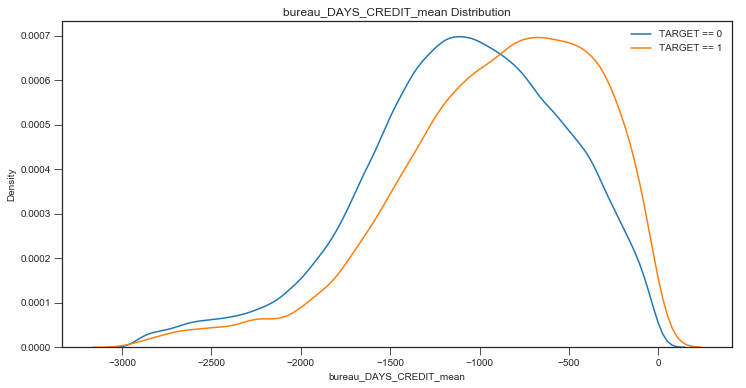

In [23]:
kde_target('bureau_DAYS_CREDIT_mean', app_train)

这是在Home Credit申请贷款之前申请上一笔贷款的天数。 因此，较大的负数表示贷款在当前贷款申请之前更久一些。 我们看到这个变量的平均值与目标之间存在极其微弱的正相关关系，这意味着过去申请贷款的客户可能更有可能在Home Credit偿还贷款。 虽然这种相关性很弱，但它与信号一样可能是噪声。

In [24]:
# 将原来的数据聚合功能封装成一个函数
def agg_numeric(df, group_var, df_name):
    '''Aggregates the numeric values in a dataframe. This can be used to create features for each instance of the grouping variable
    
    Args:
        df(dataframe):
            the dataframe to calculate the statistics on
        group_var(string):
            the variable by which to group df
        df_name(string):
            the variable used to rename the columns
    
    Return
        agg(dataframe):
            a dataframne with the statistics aggregated for all numeric columns. Each instance of the grouping variable will have 
            the statistics(mean, max, min, sum; currently supported)calculated. The columns are also renamed to keep track of 
            features created.
    '''
    
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns=col)
    
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids
    
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
    
    columns = [group_var]
    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s' %(df_name, var, stat))
    agg.columns = columns
    return agg

In [25]:
bureau_agg_new = agg_numeric(bureau.drop(columns=['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')

In [26]:
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


### Correlation Function

In [27]:
def target_corrs(df):
    corrs = []
    for col in df.columns:
        print(col)
        if col != 'TARGET':
            corr = df['TARGET'].corr(df[col])
            corrs.append(corr)
    corrs = sorted(corrs, key=lambda x:abs(x[1]), reverse=True)
    return corrs

### Categorical Variable 类别变量
处理bureau中的类别变量

In [28]:
# 对object类型进行one-hot编码
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [29]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1      ...  CREDIT_TYPE_Microloan       \
                                  sum mean ...                    sum mean   
SK_ID_CURR                                 ...                               
100001                              7  1.0 ...                      0  0.0   
100002                              8  1.0 ...                      0  0.0   
100003                              4  1.0 ...                      0  0.0   
100004                              2  1.0 ...                      0  0.0   
100005                              3  1.0 ...                      0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

sum列表示关联客户端的类别计数，mean表示规范化计数。 单热编码使得计算这些数字的过程非常简单！

我们可以使用与以前类似的功能来重命名列。 同样，我们必须处理列的多级索引。 我们遍历第一级（级别0），这是附加了类别值的分类变量的名称（来自单热编码）。 然后我们迭代我们为每个客户计算的统计数据。 我们将使用附加了stat的0级名称重命名该列。 例如，CREDIT_ACTIVE_Active为级别0且sum为级别1的列将变为CREDIT_ACTIVE_Active_count。

In [30]:
categorical_grouped.columns.levels[0][:10]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan'],
      dtype='object')

In [31]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [32]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


sum列记录计数，而mean列记录标准化计数。

我们可以将此数据框合并到训练数据中。

In [33]:
app_train.shape

(307511, 183)

In [34]:
app_train.iloc[:10, 123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,...,8.0,-499.875000,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,...,4.0,-816.000000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,2.0,-867.000000,-408.0,-1326.0,-1734.0,2.0,0.0,0.0,0.0,0.0,...,2.0,-532.000000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,-1149.000000,-1149.0,-1149.0,-1149.0,1.0,0.0,0.0,0.0,0.0,...,1.0,-783.000000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0
5,3.0,-757.333333,-78.0,-1097.0,-2272.0,3.0,0.0,0.0,0.0,0.0,...,3.0,-611.000000,-16.0,-1027.0,-1833.0,0.0,NaN,NaN,NaN,0.0
6,18.0,-1271.500000,-239.0,-2882.0,-22887.0,18.0,0.0,0.0,0.0,0.0,...,18.0,-851.611111,-23.0,-2152.0,-15329.0,0.0,NaN,NaN,NaN,0.0
7,2.0,-1939.500000,-1138.0,-2741.0,-3879.0,2.0,0.0,0.0,0.0,0.0,...,2.0,-578.000000,-18.0,-1138.0,-1156.0,0.0,NaN,NaN,NaN,0.0
8,4.0,-1773.000000,-1309.0,-2508.0,-7092.0,4.0,0.0,0.0,0.0,0.0,...,4.0,-1454.750000,-965.0,-2172.0,-5819.0,0.0,NaN,NaN,NaN,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 将处理类别变量的方法整合为一个函数

为了使代码更有效，我们现在可以编写一个函数来为我们处理分类变量。 这将采用与agg_numeric函数相同的形式，因为它接受数据帧和分组变量。 然后，它将计算数据框中所有分类变量的每个类别的计数和标准化计数。

In [35]:
def count_categorical(df, group_var, df_name):
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [36]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


## 操作其他数据表
我们现在转向bureau_balance表。 此表包含有关每个客户以前与其他金融机构的贷款的月度信息。 我们将首先按SK_ID_BUREAU（即先前贷款的ID）对数据帧进行分组，而不是使用客户端ID SK_ID_CURR对此数据帧进行分组。 这将为每笔贷款提供一行数据框。 

然后，我们可以按SK_ID_CURR进行分组，并计算每个客户贷款的汇总。 最终结果将是每个客户一行的数据框，并计算其贷款的统计数据。

In [37]:
bureau_balance = pd.read_csv('./Data/bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


首先，我们可以计算每笔贷款的每个状态的价值计数。 幸运的是，我们已经有了一个为我们做这个的功能！

In [38]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


现在我们可以处理一个数字列。 MONTHS_BALANCE列具有“相对于申请日期的平衡月数”。 

这可能不一定像数字变量那样重要，在未来的工作中我们可能希望将其视为时间变量。 现在，我们可以像以前一样计算相同的聚合统计数据。

In [39]:
# Calculate value count statistics for each `SK_ID_CURR` 
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


上述数据框架对每笔贷款进行了计算。 现在我们需要为每个客户端聚合这些。 我们可以通过首先将数据帧合并在一起，然后由于所有变量都是数字，我们只需要再次聚合统计数据，这次按SK_ID_CURR进行分组。

In [40]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [41]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


回顾一下，对于bureau_balance数据帧，我们：

- 按每笔贷款计算的数字统计数据
- 通过贷款对每个分类变量进行分组的值计数
- 合并贷款的统计数据和价值计数
- 按客户端ID计算结果数据帧分组的数字统计信息

最终结果数据框为每个客户提供一行，并为其所有贷款计算每月余额信息的统计数据。

其中一些变量有点令人困惑，所以让我们试着解释几个：

- client_bureau_balance_MONTHS_BALANCE_mean_mean：对于每笔贷款，计算MONTHS_BALANCE的平均值。然后为每个客户计算所有贷款的该值的平均值。
- client_bureau_balance_STATUS_X_count_norm_sum：对于每笔贷款，计算STATUS == X的出现次数除以贷款的总STATUS值的数量。然后，为每个客户添加每笔贷款的值。
我们将推迟计算相关性，直到我们将所有变量放在一个数据帧中。

## 将所有函数放在一起

我们现在已经准备好所有部分，以获取其他机构以前贷款的信息以及有关这些贷款的月度付款信息，并将其纳入主要培训数据框。 让我们重置所有变量，然后使用我们构建的函数从头开始执行此操作。 这证明了将函数用于可重复工作流程的好处！

In [42]:
# Free up memory by deleting old objects
import gc
gc.enable()
del app_train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

105

In [43]:
# Read in new copies of all the dataframes
train = pd.read_csv('./Data/application_train.csv')
bureau = pd.read_csv('./Data/bureau.csv')
bureau_balance = pd.read_csv('./Data/bureau_balance.csv')

## Counts of Bureau Dataframe

In [44]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


## Aggregated Stats of Bureau Dataframe

In [45]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


## Value counts of Bureau Balance dataframe by loan

In [46]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


## Aggregated stats of Bureau Balance dataframe by loan

In [47]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


## Aggregated Stats of Bureau Balance by Client

In [48]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

## Insert Computed Features into Training Data

In [49]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [50]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [51]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


## 特征工程输出

完成所有这些工作之后，现在我们想看看我们创建的变量。我们可以看一下缺失值的百分比，变量与目标的相关性，以及变量与其他变量的相关性。变量之间的相关性可以显示我们是否具有共线变量，即彼此高度相关的变量。通常，我们想要删除一对共线变量中的一个，因为两个变量都是多余的。我们还可以使用缺失值的百分比来删除具有绝大多数不存在的值的要素。特征选择将是一个重要的焦点，因为减少特征的数量可以帮助模型在训练期间学习，并且更好地概括测试数据。 “维度的诅咒”是由于具有太多特征（维度太高）而导致的问题的名称。随着变量数量的增加，学习这些变量与目标值之间关系所需的数据点数量呈指数增长。

特征选择是删除变量的过程，以帮助我们的模型更好地学习和概括测试集。目标是删除无用/冗余变量，同时保留有用的变量。我们可以使用许多工具来完成此过程，但在此笔记本中，我们将坚持删除具有高百分比缺失值的列和彼此具有高相关性的变量。稍后我们可以看一下使用从Gradient Boosting Machine或Random Forest等模型返回的特征重要性来执行特征选择。

## 缺失值处理
一个重要的考虑因素是数据框中缺少的值。 可能必须删除具有太多缺失值的列。

In [52]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [53]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has 333 columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


我们看到有许多列具有较高的缺失值百分比。 没有明确的阈值来删除缺失值，最佳的行动方案取决于问题。 在这里，为了减少功能的数量，我们将删除训练或测试数据中缺失值超过90％的任何列。

In [54]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

0

在删除缺失值之前，我们将在测试数据中找到缺失的值百分比。 然后，我们将删除训练或测试数据中缺失值超过90％的任何列。 现在让我们读入测试数据，执行相同的操作，并查看测试数据中的缺失值。 我们已经计算了所有计数和聚合统计数据，因此我们只需要将测试数据与适当的数据合并。

## 操作Test数据集


In [55]:
# Read in the test dataframe
test = pd.read_csv('./Data//application_test.csv')

# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [56]:
print('Shape of Testing Data:', test.shape)

Shape of Testing Data: (48744, 332)


### align对齐
我们需要调整测试和训练数据框架，这意味着匹配列，使它们具有完全相同的列。 这不应该是一个问题，但是当我们对热变换编码时，我们需要对齐数据帧以确保它们具有相同的列。

In [57]:
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

In [58]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


数据帧现在具有相同的列（训练数据中的TARGET列除外）。 这意味着我们可以在机器学习模型中使用它们，这需要在训练和测试数据框架中看到相同的列。

现在让我们看一下测试数据中缺失值的百分比，这样我们就可以找出应该删除的列。

In [59]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has 332 columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [60]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [61]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [62]:
# Drop the missing columns
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

我们最终在此回合中没有删除任何列，因为没有列缺失值超过90％的列。 我们可能必须应用另一种特征选择方法来减少维度。

此时我们将保存培训和测试数据。 我鼓励任何人尝试不同的百分比来删除缺失的列并比较结果。

In [63]:
train.to_csv('./Data/train_bureau_raw.csv', index = False)
test.to_csv('./Data/test_bureau_raw.csv', index = False)

## Correlations
首先让我们看一下变量与目标的相关性。 我们可以看到，我们创建的任何变量都具有比训练数据中已存在的变量（来自应用程序）更大的相关性。

In [64]:
# Calculate all correlations in dataframe
corrs = train.corr()
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [65]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


与目标相关的最高相关变量（除了TARGET当然具有1的相关性）是我们创建的变量。 然而，仅仅因为变量是相关的并不意味着它将是有用的，我们必须记住，如果我们生成数百个新变量，一些变量将与目标相关，仅仅是因为随机噪声。

怀疑地查看相关性，看起来确实有几个新创建的变量可能有用。 为了评估变量的“有用性”，我们将查看模型返回的特征重要性。 为了好奇（并且因为我们已经编写了函数），我们可以创建两个新创建的变量的kde图。

In [66]:
kde_target(var_name='client_bureau_balance_counts_mean', df=train)

KeyError: 'client_bureau_balance_counts_mean'

此变量表示每个客户的每个贷款的月平均记录数。 例如，如果客户在月度数据中有三个以前的3个，4个和5个记录的贷款，那么这个变量的值将是4.根据分布，每个贷款的平均月度记录数量更多的客户 更有可能通过Home Credit偿还贷款。 让我们不要过多地了解这个值，但它可能表明曾经拥有更多信用记录的客户通常更有可能偿还贷款。

The correlation between bureau_CREDIT_ACTIVE_Active_count_norm and the TARGET is 0.0774
Median value for loan that was not repaid = 0.5000
Median value for loan that was repaid =     0.3636


C:\Users\L\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\L\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


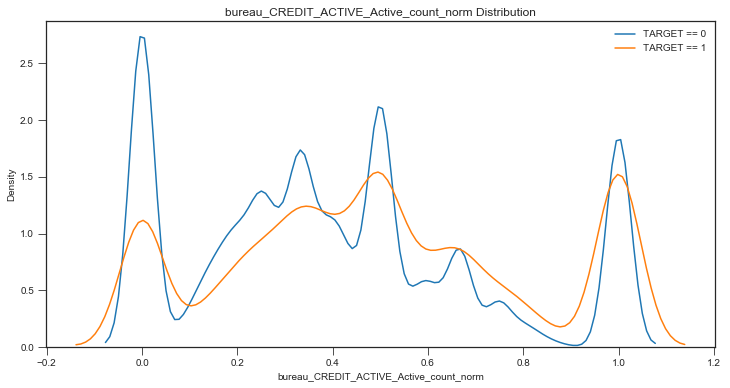

In [67]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

那么这个分布到处都是。 此变量表示CREDIT_ACTIVE值为Active的先前贷款数除以客户的先前贷款总数。 这里的相关性非常弱，我认为我们不应该得出任何结论！

## 共线变量
我们不仅可以计算变量与目标的相关性，还可以计算<b>每个变量与其他变量</b>的相关性。 这将允许我们查看是否存在应该从数据中删除的高共线变量。

让我们寻找与其他变量具有大于0.8相关性的任何变量。

In [68]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

#### 对于这些高度相关变量对中的每一对，我们只想删除其中一个变量。 以下代码通过仅添加每对中的一个来创建要删除的变量集。

In [69]:
# 跟踪要删除和已检查的列
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)

我们可以从训练和测试数据集中删除这些列。 我们将不得不在删除这些变量后将性能与保持这些变量（我们之前保存的原始csv文件）的性能进行比较。

In [70]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print(f'Train Corrs Removed Shape: {train_corrs_removed.shape}')
print(f'Test Corrs Removed ShapeL: {test_corrs_removed.shape}')

Train Corrs Removed Shape: (307511, 199)
Test Corrs Removed ShapeL: (48744, 198)


In [71]:
train_corrs_removed.to_csv('./Data/train_bureau_corrs_removed.csv', index=False)
test_corrs_removed.to_csv('./Data/test_bureau_corrs_removed.csv', index=False)

## Modeling
为了实际测试这些新数据集的性能，我们将尝试将它们用于机器学习！ 在这里，我们将使用我在另一个笔记本中开发的函数来比较功能（原始版本与高度相关的变量被删除）。 我们可以像实验一样运行这种控制，并且当提交给竞争对手时，控制将是该功能中的应用数据的性能。 我已经记录了这个性能，所以我们可以列出我们的控制和我们的两个测试条件：

#### 对于所有数据集，请使用下面显示的模型（使用精确的超参数）。

- control: only the data in the application files.
- test one: the data in the application files with all of the data recorded from the bureau and bureau_balance files
- test two: the data in the application files with all of the data recorded from the bureau and bureau_balance files with highly - - correlated variables removed.

In [72]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [127]:
def model(features, test_features, encoding='ohe', n_folds = 5):
    '''Train and test a light gradient boosting model using cross validation.
    
    Parameters:
        features:
            dataframe of training features to use for training model.Must include the TARGET column.
        test_features:
            dataframe of testing features to use for making predictions with the model.
        encoding:
            method for encoding categorical variables.Either 'ohe' for one-hot encoding or 'le' for integer label encoding
        n_folds:
            number of folds to use for cross validation.
    
    Return:
        submission:
            dataframe with 'SK_ID_CURR' and 'TARGET' probabilities predicted by the model.
        feature_importances:
            dataframe with the feature importances from the model.
        valid_metrics:
            dataframe with training and validation metrics(ROC AUC) for each fold and overall.
    '''
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframe by the columns
        features, test_features = features.align(test_features, join='inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
        
    elif encoding == 'le':
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape(-1,))
                
                # Record the categorical indices
                cat_indices.append(i)
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
    
    print('Training Data Shape:', features.shape)
    print('Testing Data Shape:', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary',
                                  class_weight = 'balanced', learning_rate = 0.05,
                                  reg_alpha = 0.1, reg_lambda = 0.1,
                                  subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                 eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                 eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                 early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                           'train': train_scores,
                           'valid': valid_scores})
    return submission, feature_importances, metrics

In [128]:
def plot_feature_importances(df):
    '''
    绘制模型返回的重要性。更高的重要性更好，这可以适用于任何特征重要性的度量。
    
    Args:
        df:
            feature importances.Must have the features in a column called 'features' and the 
            importances in a column called 'importance'
    Returns:
            shows a plot of the 15 most importance features
        df:
            feature importances sorted by importance(highest to lowest) with a column for
            normalized importance
    '''
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most importance on top
    ax.barh(list(reversed(list(df.index[:15]))),
           df['importance_normalized'].head(15),
           align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance')
    plt.ylabel('Feature Importances')
    plt.show()
    
    return df

## Control
任何实验的第一步是建立一个控制。 为此，我们将使用上面定义的函数（实现Gradient Boosting Machine模型）和单个主数据源（application）。

In [111]:
train_control = pd.read_csv('./Data/application_train.csv')
test_control = pd.read_csv('./Data/application_test.csv')

In [129]:
submission, fi, metrics = model(train_control, test_control)

Training Data Shape: (307511, 241)
Testing Data Shape: (48744, 241)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.760007	train's auc: 0.798103
Early stopping, best iteration is:
[269]	valid's auc: 0.760273	train's auc: 0.809199
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.76114	train's auc: 0.798328
Early stopping, best iteration is:
[289]	valid's auc: 0.761398	train's auc: 0.812654
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.750232	train's auc: 0.79964
Early stopping, best iteration is:
[265]	valid's auc: 0.750451	train's auc: 0.809734
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.759831	train's auc: 0.797797
Early stopping, best iteration is:
[282]	valid's auc: 0.760245	train's auc: 0.811121
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.76071	train's auc: 0.798106
Early stopping, best iteration

In [130]:
metrics

,fold,train,valid
0,0,0.809199,0.760273
1,1,0.812654,0.761398
2,2,0.809734,0.750451
3,3,0.811121,0.760245
4,4,0.802236,0.760972
5,overall,0.808989,0.758635


由于训练分数高于验证分数，控制稍微过度。 当我们查看正则化时，我们可以在后面的笔记本中解决这个问题（我们已经通过使用reg_lambda和reg_alpha以及提前停止在此模型中执行了一些正则化）。

我们可以使用另一个函数plot_feature_importances来显示特征重要性。 在选择特征时，功能重要性可能很有用。

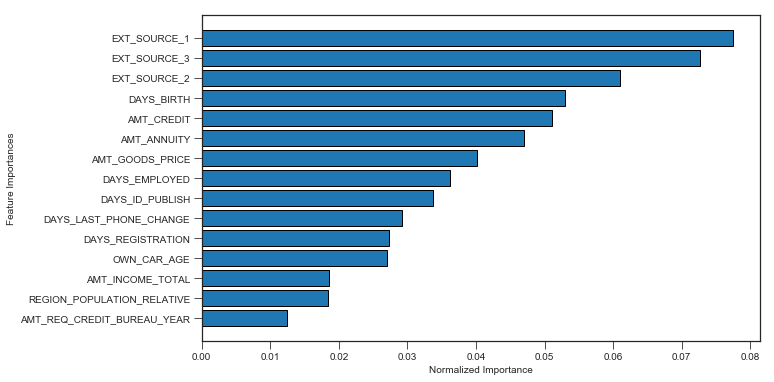

In [131]:
fi_sorted = plot_feature_importances(fi)

In [132]:
submission.to_csv('./Data/control.csv', index = False)

In [133]:
submission_raw, fi_raw, metrics_raw = model(train, test)

Training Data Shape: (307511, 452)
Testing Data Shape: (48744, 452)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.766471	train's auc: 0.810385
Early stopping, best iteration is:
[293]	valid's auc: 0.767203	train's auc: 0.827287
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.767523	train's auc: 0.810288
Early stopping, best iteration is:
[265]	valid's auc: 0.768109	train's auc: 0.822264
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.761029	train's auc: 0.811653
Early stopping, best iteration is:
[267]	valid's auc: 0.761625	train's auc: 0.824147
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.767837	train's auc: 0.809671
Early stopping, best iteration is:
[236]	valid's auc: 0.76815	train's auc: 0.816322
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.767516	train's auc: 0.809788
[400]	valid's auc: 0.767583	

In [134]:
metrics_raw

,fold,train,valid
0,0,0.827287,0.767203
1,1,0.822264,0.768109
2,2,0.824147,0.761625
3,3,0.816322,0.768150
4,4,0.828518,0.767902
5,overall,0.823708,0.766597


基于这些数字，工程特征的性能优于控制案例。 但是，在我们可以说这个更好的验证性能是否转移到测试数据之前，我们必须将预测提交到排行榜。

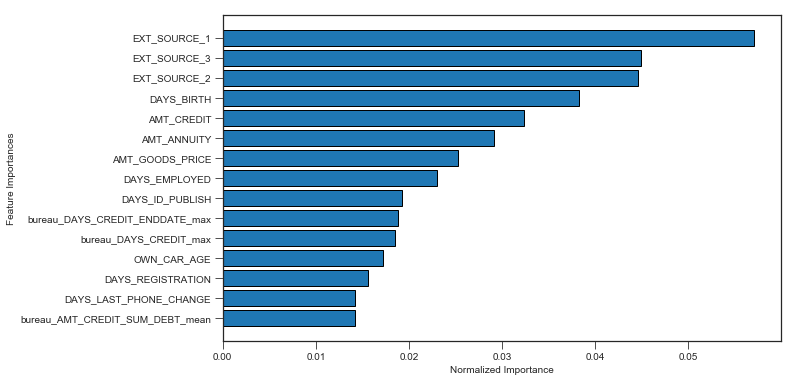

In [135]:
fi_raw_sorted = plot_feature_importances(fi_raw)

检查特征重要性，看起来我们构建的一些特征是最重要的。 让我们来看看我们在这款笔记本中制作的前100个最重要功能的百分比。 但是，我们需要与单热编码的原始功能进行比较，而不是仅仅与原始功能进行比较。 这些已经在fi中记录（来自原始数据）。

In [138]:
top_100 = list(fi_raw_sorted['feature'])[:100]
new_features = [x for x in top_100 if x not in list(fi['feature'])]
print(f'% of Top 100 Features created from the bureau data = {len(new_features):.2f}')

% of Top 100 Features created from the bureau data = 53.00


前100个功能中超过一半是由我们制作的！ 这应该让我们相信，我们所做的所有努力都是值得的。

In [140]:
submission_raw.to_csv('./Data/test_one.csv', index = False)

<b>在提交给比赛时，测试一个得分为0.759。

Test Two

此步骤删除高共线变量

In [141]:
submission_corrs, fi_corrs, metrics_corr = model(train_corrs_removed, test_corrs_removed)

Training Data Shape: (307511, 318)
Testing Data Shape: (48744, 318)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.764122	train's auc: 0.8063
Early stopping, best iteration is:
[264]	valid's auc: 0.764565	train's auc: 0.817897
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.7652	train's auc: 0.806611
[400]	valid's auc: 0.765625	train's auc: 0.839251
Early stopping, best iteration is:
[379]	valid's auc: 0.765829	train's auc: 0.836334
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.757092	train's auc: 0.808063
Early stopping, best iteration is:
[198]	valid's auc: 0.757149	train's auc: 0.807627
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.764131	train's auc: 0.806097
Early stopping, best iteration is:
[287]	valid's auc: 0.76481	train's auc: 0.821551
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.763964	trai

In [142]:
metrics_corr

,fold,train,valid
0,0,0.817897,0.764565
1,1,0.836334,0.765829
2,2,0.807627,0.757149
3,3,0.821551,0.764810
4,4,0.825298,0.764449
5,overall,0.821741,0.763352


这些结果优于对照，但略低于原始特征。

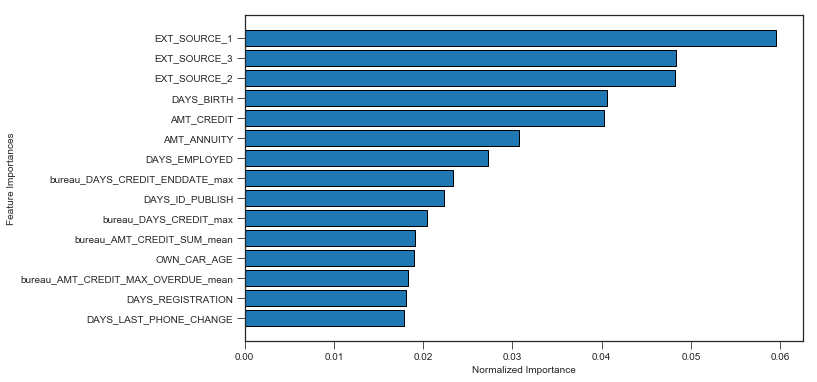

In [143]:
fi_corrs_sorted = plot_feature_importances(fi_corrs)

In [144]:
submission_corrs.to_csv('./Data/test_two.csv', index = False)

## 总结
完成所有这些工作之后，我们可以说包含额外信息确实提高了性能！ 该模型绝对没有针对我们的数据进行优化，但在使用计算出的特征时，我们仍然比原始数据集有了明显的改进。 让我们正式总结一下表现：

|Experiment	|Train AUC|	Validation AUC|	Test AUC|
|-----------|-------|-------------|------|
|Control|0.815|	0.760|0.745|
|Test One|	0.837|	0.767|	0.759|
|Test Two|	0.826|	0.765|	0.753|

我们所有的努力工作都转化为比原始测试数据小0.014 ROC AUC的改进。 删除高共线变量会略微降低性能，因此我们需要考虑不同的特征选择方法。 此外，我们可以说，我们构建的一些功能是模型判断最重要的功能之一。

在这样的竞争中，即使是这种尺寸的改进也足以让我们在排行榜上占据100多个位置。 通过在这款笔记本中进行多项小改进，我们可以逐步实现更好，更好的性能。 我鼓励其他人在这里使用结果进行自己的改进，我将继续记录我采取的帮助他人的步骤。

## 下一步
展望未来，我们现在可以在其他数据集中使用我们在此笔记本中开发的功能。 我们的模型中还有4个其他数据文件可供使用！ 在下一个笔记本中，我们将把这些其他数据文件（其中包含Home Credit的先前贷款信息）的信息合并到我们的训练数据中。 然后我们可以构建相同的模型并运行更多实验来确定我们的特征工程的效果。 在这场比赛中还有很多工作要做，还有更多的表现！ 我会在下一本笔记本中看到你。

在本笔记本中，我们将扩展手册功能工程笔记本简介。 我们将使用该笔记本中开发的聚合和值计数功能，以便合并来自previous_application，POS_CASH_balance，installments_payments和credit_card_balance数据文件的信息。 我们已经使用了之前笔记本中的局和Bureau_balance的信息，并且与仅使用应用程序数据相比，我们能够提高我们的竞争分数。 在运行具有此处所包含功能的模型后，性能确实会提高，但是我们会遇到功能数量激增的问题！ 我正在开发一个功能选择笔记本，但对于这款笔记本，我们将继续为我们的模型构建一组丰富的数据。

四个附加数据文件的定义是：

- previous_application（previous）：以前申请贷款的房屋贷款申请数据的客户。 应用程序数据中的每个当前贷款可以具有多个先前的贷款。 每个先前的应用程序都有一行，并由功能SK_ID_PREV标识。
- POS_CASH_BALANCE（cash）：有关以前销售点或客户现金贷款的家庭信贷的月度数据。 每行是前一个销售点或现金贷款的一个月，而前一个贷款可以有多行。
- credit_card_balance（credit）：有关以前信用卡客户使用归属信用卡的月度数据。 每行是信用卡余额的一个月，单个信用卡可以有多行。
- installments_payment（installment）：Home Credit的先前贷款的付款历史记录。 每次付款都有一行，每次错过付款都有一行。

我们花了很多时间在以前的笔记本中开发两个函数：

- agg_numeric：计算数值变量的聚合统计信息（mean，count，max，min）。

- agg_categorical：计算分类变量中每个类别的计数和标准化计数。

这两个函数一起可以提取有关数据框中数字和分类数据的信息。 我们的一般方法是将这两个函数应用于数据框，按客户端ID SK_ID_CURR进行分组。 对于POS_CASH_balance，credit_card_balance和installment_payments，我们可以先按SK_ID_PREV分组，即先前贷款的唯一ID。 然后，我们将通过SK_ID_CURR对结果数据帧进行分组，以计算每个客户在其所有先前贷款中的汇总统计数据。 如果这有点令人困惑，我建议回到第一个功能工程笔记本。**

### Function to Convert Data Types
这将通过为变量使用更有效的类型来帮助减少内存使用量。 例如，类别通常是比对象更好的类型（除非唯一类别的数量接近数据框中的行数）。

In [147]:
import sys

def reutrn_size(df):
    '''Return size of dataframe in gigabytes'''
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif(df[c].dtype == 'object') and (df[c].nunique()<df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
        
        # Int64 to float32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Mermory Usage:{round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage:{round(new_memory / 1e9, 2)} gb.')
    
    return df

我们一次处理一个数据集。 首先是previous_applications。 客户在Home Credit的每笔贷款都有一行。 客户可以拥有多个先前的贷款，这就是我们需要汇总每个客户的统计数据的原因。

In [148]:
previous = pd.read_csv('./Data/previous_application.csv')
previous = convert_types(previous, print_info=True)
previous.head()

Original Mermory Usage:0.49 gb.
New Memory Usage:0.18 gb.


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
def new_agg_numeric(df, parent_var, df_name):
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
    
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids
    
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean','max', 'min', 'sum'])
    
    columns = []
    
    for var in agg.columns.levels[0]:
        if var != parent_var:
            for stat in agg.columns.levels[1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index = True)
    agg = agg.iloc[:, idx]
    
    return agg

In [168]:
def new_agg_categorical(df, parent_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('category'))
    categorical[parent_var] = df[parent_var]
    
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    for var in categorical.columns.levels[0]:
        for stat in ['sum', 'count', 'mean']:
            column_names.append('%s_%s_%s' %(df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis=1, return_index=True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [163]:
previous_agg = new_agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape:', previous_agg.shape)
previous_agg.head()

Previous aggregation shape: (338857, 80)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
previous_counts = new_agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape:', previous_counts.shape)
previous_counts.head()

Previous aggregation shape: (338857, 285)


,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_Animals_sum,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_GOODS_CATEGORY_House Construction_sum,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,...,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,2,2,2,2,3,3,3,3
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,2,1,2,2,2


我们可以使用合并将计算的数据帧加入主训练数据帧。 然后我们应该删除计算出的数据帧，以避免使用太多的内核内存。

In [170]:
train = pd.read_csv('./Data/application_train.csv')
train = convert_types(train)
test = pd.read_csv('./Data/application_test.csv')
test = convert_types(test)

train = train.merge(previous_counts, on = 'SK_ID_CURR', how='left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how='left')

test = test.merge(previous_counts, on = 'SK_ID_CURR', how='left')
test = test.merge(previous_agg, on='SK_ID_CURR', how='left')

gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

662

我们将不得不小心计算太多的功能。 我们不希望用太多不相关的功能或具有太多缺失值的功能来压倒模型。 在之前的笔记本中，我们删除了超过75％缺失值的任何功能。 为了保持一致，我们将在此处应用相同的逻辑。

## Function to Calculate Missing Values

In [173]:
def remove_missing_columns(train, test, threshold = 90):
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    train = train.drop(columns= missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

In [174]:
train, test = remove_missing_columns(train, test)

There are 6 columns with greater than 90% missing values.


## Applying to More Data
#### Function to Aggregate Stats at the Client Level

In [180]:
def aggregate_client(df, group_vars, df_names):
    df_agg = new_agg_numeric(df, parent_var = group_vars[0], df_name=df_names[0])
    
    if any(df.dtypes == 'category'):
        df_counts = new_agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])
        
        df_by_loan = df_counts.merge(df_agg, on=group_vars[0], how='outer')
        
        gc.enable()
        del df_agg, df_counts
        gc.collect()
        
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how='left')
        
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggragate numeric stats by column
        df_by_client = new_agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    
    # No categorical variable
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how='left')

        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns= [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = new_agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()
        
    return df_by_client

## Monthly Cash Data

In [181]:
cash = pd.read_csv('./Data/POS_CASH_balance.csv')
cash = convert_types(cash, print_info=True)
cash.head()

Original Mermory Usage:0.64 gb.
New Memory Usage:0.41 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [182]:
cash_by_client = aggregate_client(cash, group_vars= ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,...,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_sum_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_CNT_INSTALMENT_count_sum,client_cash_CNT_INSTALMENT_FUTURE_count_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-2887,-669,-653.0,-637,-378,-320.777778,-275,-96,-94.5,-93,...,28.0,32.0,36.0,36.000000,36.0,41,41,41,62.0,164.0
100002,-3610,-361,-190.0,-19,-190,-190.000000,-190,-19,-10.0,-1,...,456.0,361.0,456.0,456.000000,456.0,361,361,361,5415.0,8664.0
100003,-13240,-1348,-1226.0,-1104,-858,-472.857143,-172,-77,-71.5,-66,...,288.0,256.0,248.0,283.000000,288.0,272,272,272,1608.0,2840.0
100004,-408,-108,-102.0,-96,-102,-102.000000,-102,-27,-25.5,-24,...,16.0,12.0,12.0,15.000000,16.0,16,16,16,36.0,60.0
100005,-2420,-275,-220.0,-165,-220,-220.000000,-220,-25,-20.0,-15,...,132.0,99.0,99.0,128.699997,132.0,110,110,121,792.0,1287.0


In [183]:
print('Cash by Client Shape: ', cash_by_client.shape)
train = train.merge(cash_by_client, on='SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on='SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

Cash by Client Shape:  (337252, 165)


21

In [184]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


## Monthly Credit Data

In [185]:
credit = pd.read_csv('./Data/credit_card_balance.csv')
credit = convert_types(credit, print_info= True)
credit.head()

Original Mermory Usage:0.71 gb.
New Memory Usage:0.42 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [186]:
credit_by_client = aggregate_client(credit, group_vars= ['SK_ID_PREV', 'SK_ID_CURR'], df_names=['credit', 'client'])
credit_by_client.head()

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,client_credit_MONTHS_BALANCE_min_max,...,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_mean_min,client_credit_AMT_PAYMENT_CURRENT_mean_mean,client_credit_AMT_PAYMENT_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_max_min,client_credit_AMT_PAYMENT_CURRENT_max_mean,client_credit_AMT_PAYMENT_CURRENT_max_max,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-126,-36,-21.0,-21,-21.0,-21,-6,-6,-6.0,-6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100011,-210826,-5550,-2849.0,-2849,-2849.0,-2849,-148,-75,-75.0,-75,...,2432.432373,4843.063965,4843.063965,4843.063965,55485.0,55485.0,55485.0,180000.0,180000.0,180000.0
100013,-446976,-9216,-4656.0,-4656,-4656.0,-4656,-96,-96,-96.0,-96,...,6350.000000,7168.346191,7168.346191,7168.346191,153675.0,153675.0,153675.0,157500.0,157500.0,157500.0
100021,-2890,-306,-170.0,-170,-170.0,-170,-34,-18,-18.0,-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100023,-480,-88,-60.0,-60,-60.0,-60,-32,-11,-11.0,-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
print('Credit by client shape: ', credit_by_client.shape)
train = train.merge(credit_by_client, on = 'SK_ID_CURR', how='left')
test = test.merge(credit_by_client, on='SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

Credit by client shape:  (103558, 381)


21

In [188]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


## Installment Payments

In [189]:
installments = pd.read_csv('./Data/installments_payments.csv')
installments = convert_types(installments, print_info=True)
installments.head()

Original Mermory Usage:0.87 gb.
New Memory Usage:0.49 gb.


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [190]:
installments_by_client = aggregate_client(installments, group_vars=['SK_ID_PREV', 'SK_ID_CURR'], df_names=['installments','client'])
installments_by_client.head()

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,-8647.0,...,2.774678e+04,2.774678e+04,2.925090e+04,2.925090e+04,4.119593e+04,4.119593e+04,8.153775e+04,8.153775e+04,1.528387e+05,1.528387e+05
100002,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,-5993.0,...,1.757837e+05,1.757837e+05,2.196257e+05,2.196257e+05,2.196257e+05,2.196257e+05,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
100003,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,-25821.0,...,1.154108e+06,1.154108e+06,1.150977e+06,1.150977e+06,1.618865e+06,1.618865e+06,4.394102e+06,4.394102e+06,1.134881e+07,1.134881e+07
100004,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,-2285.0,...,1.607175e+04,1.607175e+04,2.128846e+04,2.128846e+04,2.128846e+04,2.128846e+04,3.172189e+04,3.172189e+04,6.386539e+04,6.386539e+04
100005,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,-5486.0,...,4.331880e+04,4.331880e+04,5.616184e+04,5.616184e+04,5.616184e+04,5.616184e+04,1.589062e+05,1.589062e+05,5.054566e+05,5.054566e+05


In [191]:
print('Installments by client shape:', installments_by_client.shape)

train = train.merge(installments_by_client, on='SK_ID_CURR', how='left')
test = test.merge(installments_by_client, on='SK_ID_CURR', how='left')

gc.enable()
del installments, installments_by_client
gc.collect()

Installments by client shape: (339587, 106)


14

In [192]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


In [194]:
print('Final Training Shape:', train.shape)
print('Final Testing Shape:', test.shape)

Final Training Shape: (307511, 1133)
Final Testing Shape: (48744, 1132)


In [198]:
def return_size(df):
    return round(sys.getsizeof(df)/1e9,2)
print(f'Final Training Size:{return_size(train)}')
print(f'Final Testing Size:{return_size(test)} ')

Final Training Size:2.16
Final Testing Size:0.34 


In [200]:
train.to_csv('./Data/train_previous_raw.csv', index = False, chunksize = 500)
test.to_csv('./Data/test_previous_raw.csv', index = False)

In [201]:
submission, fi, metrics = model(train, test)

Training Data Shape: (307511, 1252)
Testing Data Shape: (48744, 1252)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.779868	train's auc: 0.827313
[400]	valid's auc: 0.77973	train's auc: 0.862592
Early stopping, best iteration is:
[336]	valid's auc: 0.78019	train's auc: 0.852469
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.781401	train's auc: 0.827102
[400]	valid's auc: 0.782062	train's auc: 0.862624
Early stopping, best iteration is:
[357]	valid's auc: 0.782335	train's auc: 0.85588
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.772784	train's auc: 0.828293
Early stopping, best iteration is:
[253]	valid's auc: 0.773063	train's auc: 0.839053
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.779497	train's auc: 0.827157
Early stopping, best iteration is:
[237]	valid's auc: 0.77977	train's auc: 0.834984
Training until validation scores don't imp

In [202]:
submission.to_csv('./Data/submission_final.csv', index=False)